source: Regression and Other Stories, Gelman et al. Chapter 13

https://avehtari.github.io/ROS-Examples/Arsenic/arsenic_logistic_residuals.html

https://github.com/avehtari/ROS-Examples/tree/master/Arsenic/

In [1]:
pip install pyro-ppl

     |████████████████████████████████| 718 kB 5.2 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


A research team marked wells as safe or unsafe according to their arsenic levels. People with unsafe wells were encouraged to switch. A few years later, they returned to study who had actually switched.

Inputs
- The distance to the closest known safe well
- The arsenic level of respondent's well
- Whether any members of household are active in community organizations
- The education level of the head of household

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/seanreed1111/RAOS-Examples/master/Arsenic/data/wells.csv")
df.head()

,switch,arsenic,dist,dist100,assoc,educ,educ4
0,1,2.36,16.826000,0.16826,0,0,0.0
1,1,0.71,47.321999,0.47322,0,0,0.0
2,0,2.07,20.966999,0.20967,0,10,2.5
3,1,1.15,21.486000,0.21486,0,12,3.0
4,1,1.10,40.874001,0.40874,1,14,3.5


In [4]:
df['switch'].value_counts()[1] / df['switch'].count() * 100    # percentage of dataset that switched

57.51655629139073

In [5]:
df = df[['switch', 'arsenic', 'dist100', 'assoc', 'educ4']] #remove dist and educ
df.describe().T

,count,mean,std,min,25%,50%,75%,max
switch,3020.0,0.575166,0.494400,0.00000,0.000000,1.000000,1.00000,1.00000
arsenic,3020.0,1.656930,1.107387,0.51000,0.820000,1.300000,2.20000,9.65000
dist100,3020.0,0.483319,0.384787,0.00387,0.211172,0.367615,0.64041,3.39531
assoc,3020.0,0.422848,0.494093,0.00000,0.000000,0.000000,1.00000,1.00000
educ4,3020.0,1.207119,1.004329,0.00000,0.000000,1.250000,2.00000,4.25000


Note that the max safe arsenic level is 0.5 on this scale. 
So all people in this dataset live near an unsafe well, and the worst well is ~ 20x more arsenic than the safe levels!

In [6]:
X = df.copy() # note: data not centered

In [7]:
# Everyone in this dataset used a well considered at an unsafe arsenic level (0.5 is considered safe). 
# Let's examine the arsenic levels in the dataset

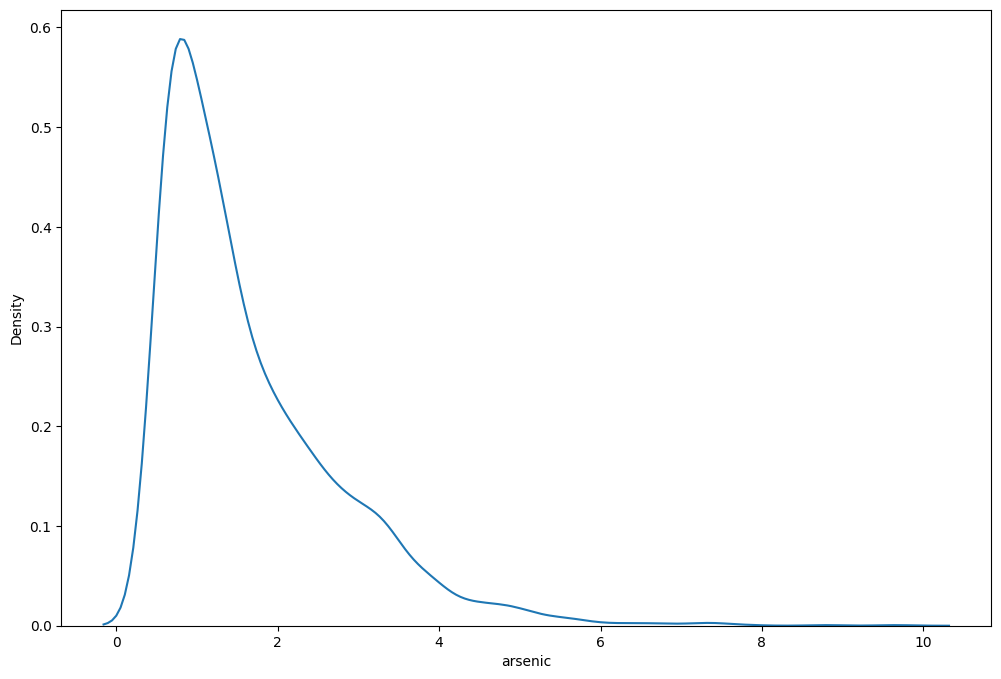

In [8]:
sns.kdeplot(data=X['arsenic'])

In [9]:
#let's try to cut the arsenic levels into buckets

In [10]:
X['arsenic'].describe()

count    3020.000000
mean        1.656930
std         1.107387
min         0.510000
25%         0.820000
50%         1.300000
75%         2.200000
max         9.650000
Name: arsenic, dtype: float64

In [11]:
quantiles = pd.qcut(X['arsenic'], q=4)
quantiles.value_counts()

(0.509, 0.82]    758
(0.82, 1.3]      756
(1.3, 2.2]       756
(2.2, 9.65]      750
Name: arsenic, dtype: int64

In [12]:
quantiles = pd.qcut(X['arsenic'], q=4, labels=False)
quantiles.value_counts()

0    758
2    756
1    756
3    750
Name: arsenic, dtype: int64

In [13]:
quantiles

0       3
1       0
2       2
3       1
4       1
       ..
3015    0
3016    1
3017    0
3018    0
3019    0
Name: arsenic, Length: 3020, dtype: int64

In [14]:
deciles = pd.qcut(X['arsenic'], q=10)
deciles.value_counts()

(0.509, 0.62]    320
(0.62, 0.75]     312
(1.1, 1.3]       305
(1.953, 2.47]    305
(2.47, 3.21]     301
(0.9, 1.1]       300
(1.3, 1.57]      300
(1.57, 1.953]    300
(3.21, 9.65]     300
(0.75, 0.9]      277
Name: arsenic, dtype: int64

In [15]:
deciles = pd.qcut(X['arsenic'], q=10, labels=False)
deciles.value_counts()

0    320
1    312
7    305
4    305
8    301
3    300
9    300
6    300
5    300
2    277
Name: arsenic, dtype: int64

In [16]:
X['arsenic_quantiles'] = quantiles
X['arsenic_deciles'] = deciles

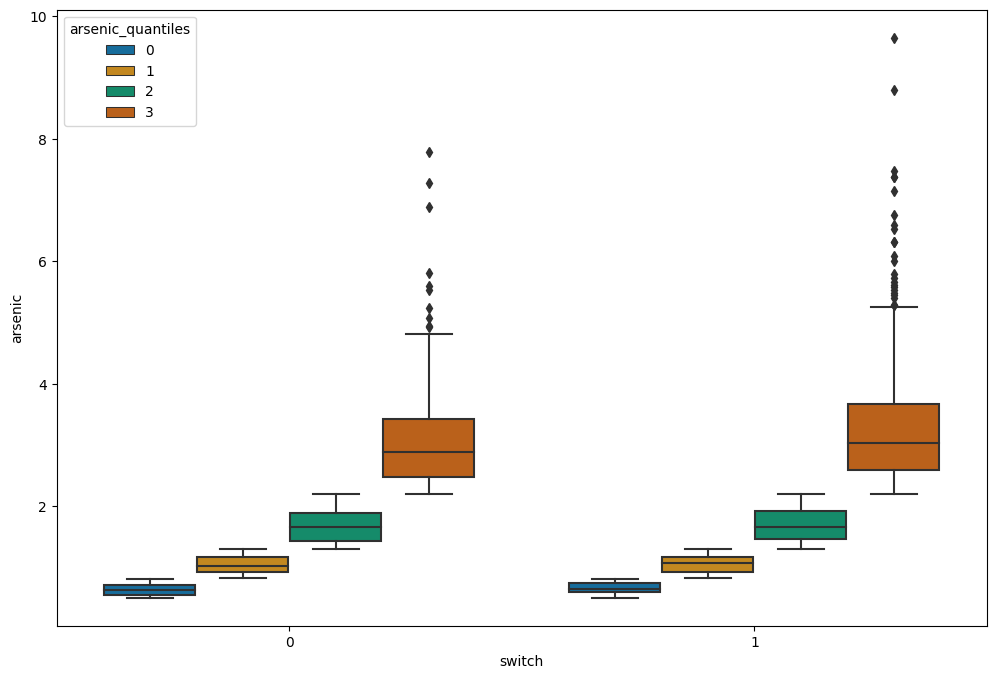

In [17]:
sns.boxplot(data=X, x='switch', y='arsenic', hue='arsenic_quantiles',palette='colorblind');

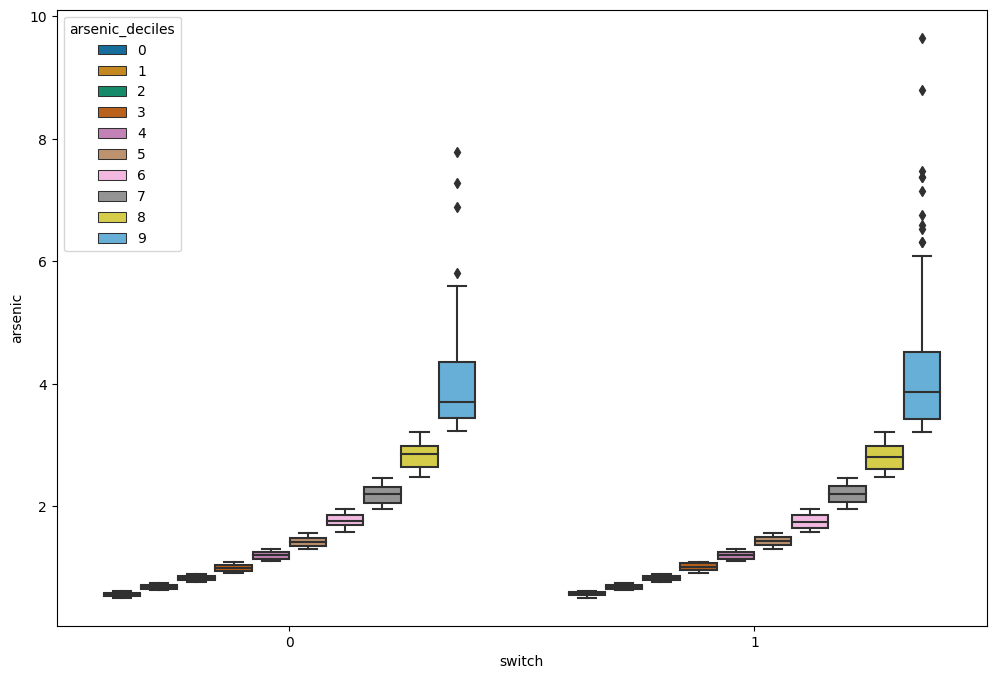

In [18]:
sns.boxplot(data=X, x='switch', y='arsenic', hue='arsenic_deciles', palette='colorblind');

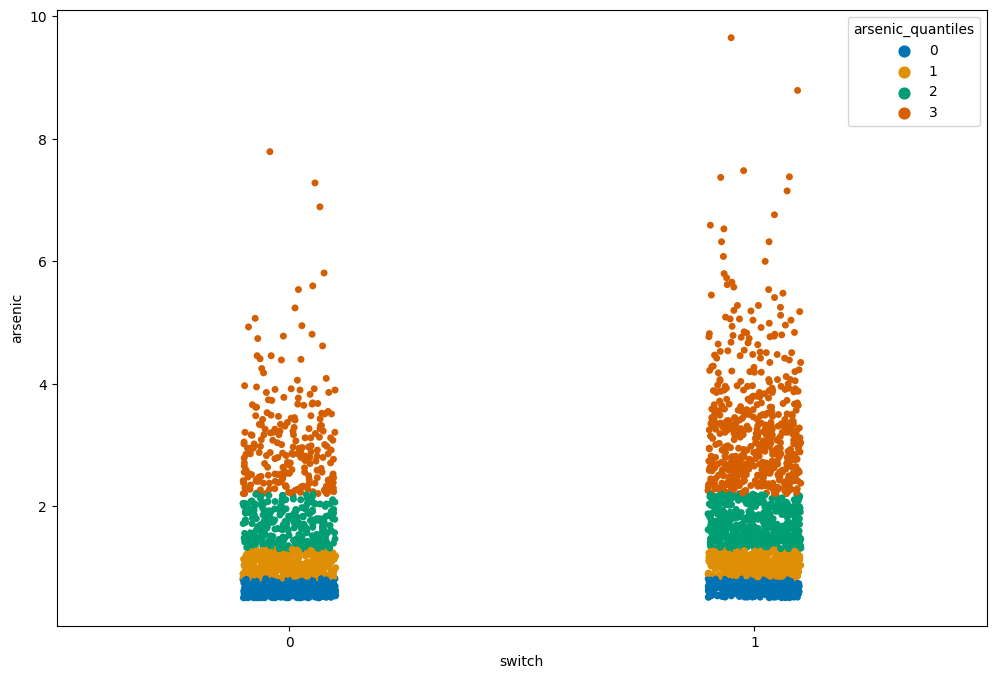

In [19]:
sns.stripplot(data=X, x='switch', y='arsenic', hue='arsenic_quantiles', palette="colorblind");

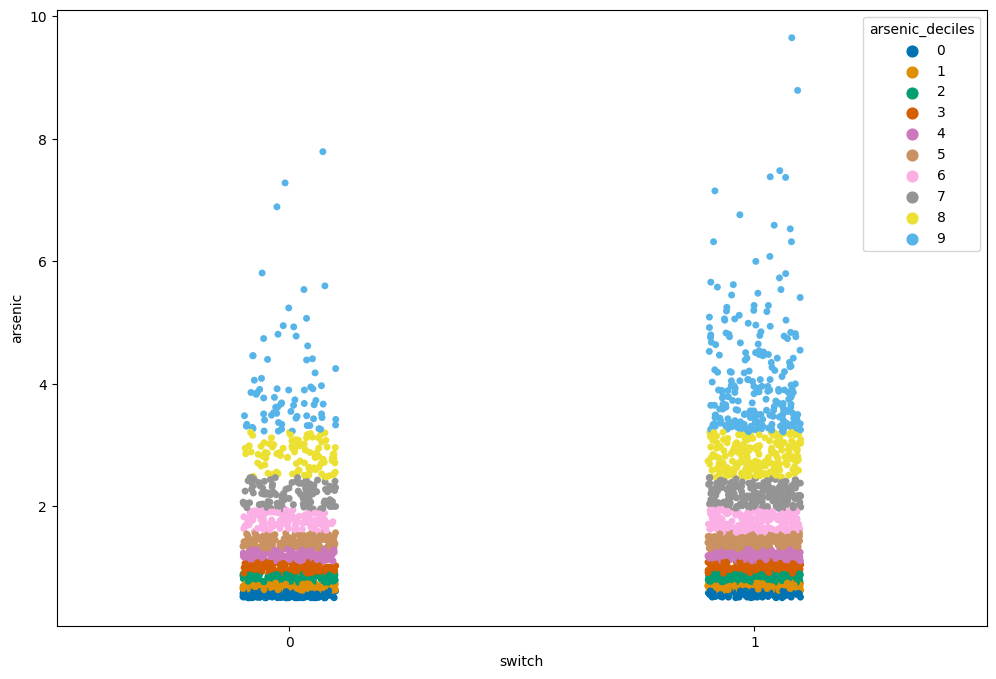

In [20]:
sns.stripplot(data=X, x='switch', y='arsenic', hue='arsenic_deciles', palette="colorblind");

In [21]:
# So looking at the data, more people in the higher arsenic levels switched

let's move on to a model with a model of 'switch ~ dist100 + arsenic' 

In [22]:
data = X[['dist100', 'arsenic']]
target = X['switch']

In [23]:
from sklearn.linear_model import LogisticRegression
# C = 1e9 means no L2 regularization
clf = LogisticRegression(C=1e9, random_state=0).fit(data, target)


In [24]:
# these are MLE estimates of parameters we expect to recover
print(clf.intercept_)
print(clf.coef_)

[0.00274999]
[[-0.89664382  0.46077421]]


## Using statsmodels

In [25]:
import statsmodels.formula.api as smf
statsmod = smf.logit(formula='switch ~ dist100 + arsenic', data=X)
result = statsmod.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Apr 2022   Pseudo R-squ.:                 0.04551
Time:                        03:02:04   Log-Likelihood:                -1965.3
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.995e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.079      0.035      0.972      -0.153       0.158
dist100       -0.8966      0.

## Using Bayesian Regression with SVI

In [26]:
# convert data and target to torch tensors
data = tensor(data.values, dtype=torch.float)
target = tensor(target.values, dtype=torch.float)

In [27]:
data.size(), target.size()

(torch.Size([3020, 2]), torch.Size([3020]))

In [28]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        if bias:
          self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))
        self.linear.weight = PyroSample(dist.Normal(0., 5.).expand([out_features, in_features]).to_event(2))

        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
            print(obs)
        return logits

In [29]:
data.size(1) #number of columns of the predictor

2

In [30]:
model = BayesianLogisticRegression(data.size(1)) 

In [31]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [32]:
def train(model, guide, lr=0.01, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")
    print(f"Final Elbo loss: {elbo}")

In [33]:
%%time
train(model, guide)

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
Elbo loss: 2085.6899132728577
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 

In [34]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

In [35]:
svi_samples.keys()

dict_keys(['linear.weight', 'linear.bias'])

In [36]:
svi_samples['linear.bias'].mean()

0.0008970631

In [37]:
svi_samples['linear.weight'].mean(axis=0)

array([-0.9060526 ,  0.46388754], dtype=float32)

In [38]:
guide.quantiles([0.05,0.50,0.95])

{'linear.bias': tensor([[-0.0707],
         [-0.0007],
         [ 0.0694]]), 'linear.weight': tensor([[[-1.0648,  0.4005]],
 
         [[-0.8981,  0.4627]],
 
         [[-0.7315,  0.5249]]])}

In [39]:
print(clf.intercept_)
print(clf.coef_)

[0.00274999]
[[-0.89664382  0.46077421]]


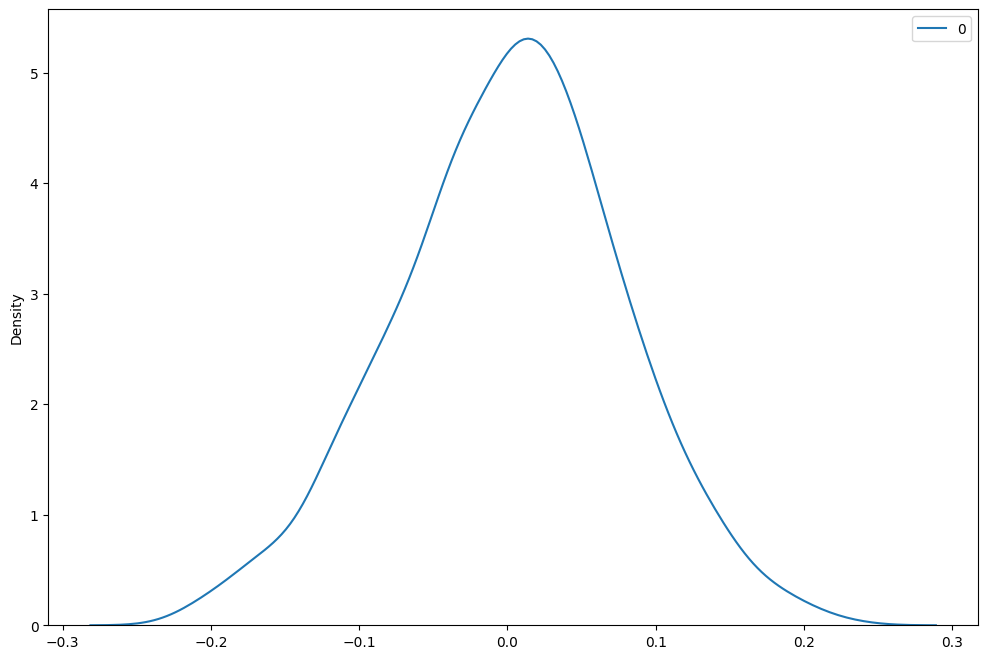

In [40]:
sns.kdeplot(data = svi_samples['linear.bias']);

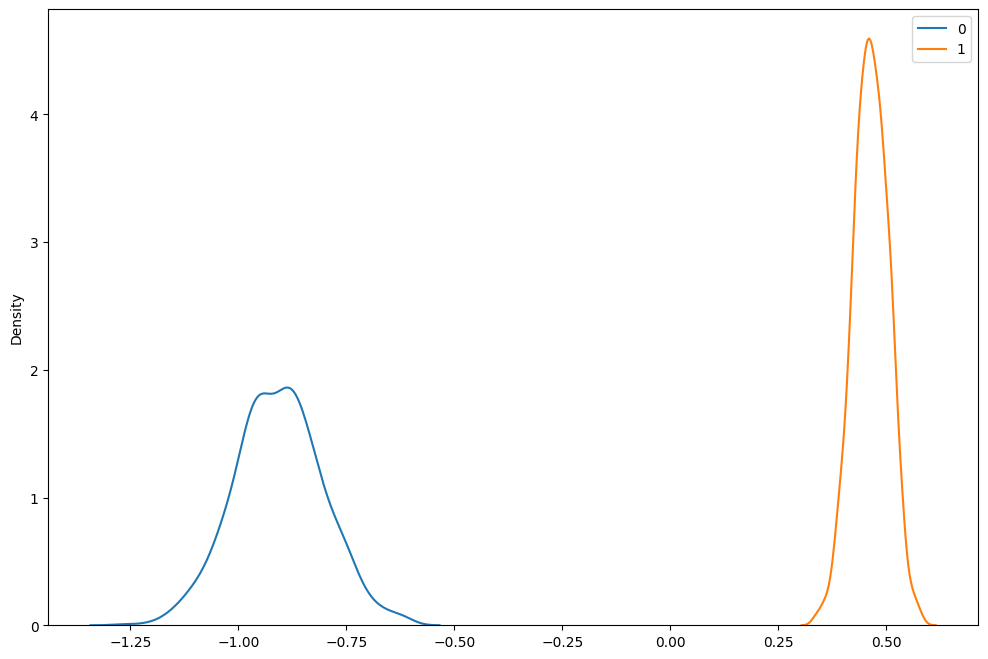

In [41]:
sns.kdeplot(data = svi_samples['linear.weight']);

In [42]:
# So all three methods seem to be in agreement about the central tendencies of the coefficients.

# What about MCMC?

In [43]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=500)

In [44]:
%%time
mcmc.run(data, target)

Warmup:   0%|          | 4/2500 [00:00, 32.98it/s, step size=1.01e-02, acc. prob=0.500]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   0%|          | 8/2500 [00:00, 15.09it/s, step size=1.67e-02, acc. prob=0.684]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   0%|          | 12/2500 [00:00, 17.85it/s, step size=1.69e-02, acc. prob=0.723]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   1%|          | 17/2500 [00:00, 16.38it/s, step size=2.25e-02, acc. prob=0.749]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   1%|          | 23/2500 [00:01, 20.35it/s, step size=1.73e-02, acc. prob=0.757]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   1%|          | 26/2500 [00:01, 21.53it/s, step size=4.37e-03, acc. prob=0.742]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   1%|          | 29/2500 [00:01, 17.91it/s, step size=2.49e-02, acc. prob=0.768]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   1%|▏         | 33/2500 [00:01, 16.45it/s, step size=2.14e-02, acc. prob=0.770]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 39/2500 [00:02, 20.08it/s, step size=1.57e-02, acc. prob=0.770]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 47/2500 [00:02, 22.18it/s, step size=1.02e-02, acc. prob=0.770]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 50/2500 [00:02, 21.05it/s, step size=4.37e-02, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 53/2500 [00:02, 18.54it/s, step size=2.56e-02, acc. prob=0.780]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 56/2500 [00:02, 18.18it/s, step size=1.43e-02, acc. prob=0.776]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   2%|▏         | 62/2500 [00:03, 20.68it/s, step size=2.44e-02, acc. prob=0.781]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 65/2500 [00:03, 20.70it/s, step size=1.05e-02, acc. prob=0.776]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 68/2500 [00:03, 16.54it/s, step size=3.45e-02, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 72/2500 [00:03, 17.45it/s, step size=2.34e-02, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 77/2500 [00:04, 18.37it/s, step size=2.75e-02, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 81/2500 [00:04, 18.03it/s, step size=2.59e-02, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   3%|▎         | 83/2500 [00:04, 18.19it/s, step size=2.30e-02, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▎         | 91/2500 [00:04, 22.99it/s, step size=9.03e-03, acc. prob=0.779]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▍         | 94/2500 [00:04, 21.54it/s, step size=2.67e-02, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▍         | 101/2500 [00:05, 23.22it/s, step size=1.10e+00, acc. prob=0.781]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▍         | 104/2500 [00:05, 20.81it/s, step size=2.22e-01, acc. prob=0.778]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▍         | 107/2500 [00:05, 20.76it/s, step size=1.60e-01, acc. prob=0.778]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   4%|▍         | 110/2500 [00:05, 21.12it/s, step size=7.19e-01, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▍         | 116/2500 [00:06, 18.61it/s, step size=4.84e-01, acc. prob=0.782]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▍         | 119/2500 [00:06, 20.34it/s, step size=1.48e-01, acc. prob=0.779]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▍         | 122/2500 [00:06, 21.15it/s, step size=2.63e-01, acc. prob=0.781]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▌         | 127/2500 [00:06, 18.17it/s, step size=5.47e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▌         | 131/2500 [00:06, 20.19it/s, step size=1.94e-01, acc. prob=0.781]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   5%|▌         | 134/2500 [00:06, 18.45it/s, step size=9.98e-02, acc. prob=0.779]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   6%|▌         | 141/2500 [00:07, 22.14it/s, step size=5.17e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   6%|▌         | 146/2500 [00:07, 28.08it/s, step size=1.97e-01, acc. prob=0.782]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   6%|▌         | 155/2500 [00:07, 28.19it/s, step size=1.61e-01, acc. prob=0.781]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   6%|▋         | 158/2500 [00:07, 23.68it/s, step size=4.66e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   6%|▋         | 161/2500 [00:08, 22.21it/s, step size=1.51e-01, acc. prob=0.782]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   7%|▋         | 165/2500 [00:08, 21.16it/s, step size=2.55e-01, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   7%|▋         | 173/2500 [00:08, 26.56it/s, step size=3.08e-01, acc. prob=0.784]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:   7%|▋         | 176/2500 [00:08, 25.97it/s, step size=9.00e-02, acc. prob=0.782]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   7%|▋         | 179/2500 [00:08, 17.30it/s, step size=2.53e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   7%|▋         | 184/2500 [00:09, 20.82it/s, step size=2.44e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   8%|▊         | 188/2500 [00:09, 21.15it/s, step size=1.53e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   8%|▊         | 194/2500 [00:09, 20.44it/s, step size=5.17e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   8%|▊         | 198/2500 [00:09, 19.93it/s, step size=2.76e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   8%|▊         | 201/2500 [00:09, 20.46it/s, step size=5.09e-01, acc. prob=0.787]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:   8%|▊         | 209/2500 [00:10, 26.04it/s, step size=8.82e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   9%|▊         | 213/2500 [00:10, 24.88it/s, step size=1.72e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   9%|▉         | 219/2500 [00:10, 24.33it/s, step size=2.85e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   9%|▉         | 227/2500 [00:10, 28.93it/s, step size=1.63e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:   9%|▉         | 231/2500 [00:11, 25.01it/s, step size=1.63e-01, acc. prob=0.786]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:   9%|▉         | 234/2500 [00:11, 22.81it/s, step size=3.31e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  10%|▉         | 238/2500 [00:11, 26.47it/s, step size=2.04e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  10%|▉         | 245/2500 [00:11, 22.85it/s, step size=4.05e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  10%|█         | 254/2500 [00:11, 31.94it/s, step size=3.58e-01, acc. prob=0.784]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:  10%|█         | 258/2500 [00:12, 30.11it/s, step size=1.21e-01, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  10%|█         | 262/2500 [00:12, 28.43it/s, step size=1.63e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█         | 266/2500 [00:12, 20.88it/s, step size=7.98e-02, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█         | 269/2500 [00:12, 16.61it/s, step size=3.96e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█         | 272/2500 [00:13, 13.21it/s, step size=1.32e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█         | 277/2500 [00:13, 16.63it/s, step size=2.08e-01, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█         | 280/2500 [00:13, 17.63it/s, step size=9.99e-02, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█▏        | 283/2500 [00:13, 16.73it/s, step size=4.89e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  11%|█▏        | 287/2500 [00:13, 19.64it/s, step size=6.38e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  12%|█▏        | 293/2500 [00:14, 20.62it/s, step size=8.32e-02, acc. prob=0.783]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  12%|█▏        | 296/2500 [00:14, 18.72it/s, step size=2.62e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  12%|█▏        | 299/2500 [00:14, 20.36it/s, step size=8.49e-02, acc. prob=0.784]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  12%|█▏        | 307/2500 [00:15, 18.16it/s, step size=2.60e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  12%|█▏        | 311/2500 [00:15, 19.92it/s, step size=1.74e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  13%|█▎        | 317/2500 [00:15, 20.55it/s, step size=2.12e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  13%|█▎        | 325/2500 [00:15, 26.27it/s, step size=4.08e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  13%|█▎        | 328/2500 [00:15, 26.46it/s, step size=1.89e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  13%|█▎        | 331/2500 [00:15, 22.20it/s, step size=5.09e-01, acc. prob=0.787]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:  13%|█▎        | 337/2500 [00:16, 20.54it/s, step size=3.12e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  14%|█▎        | 342/2500 [00:16, 25.66it/s, step size=1.91e-01, acc. prob=0.786]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  14%|█▍        | 345/2500 [00:16, 24.85it/s, step size=1.28e-01, acc. prob=0.785]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  14%|█▍        | 351/2500 [00:16, 20.75it/s, step size=4.71e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  14%|█▍        | 357/2500 [00:17, 23.47it/s, step size=3.79e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  14%|█▍        | 360/2500 [00:17, 22.25it/s, step size=1.94e-01, acc. prob=0.786]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:  15%|█▍        | 367/2500 [00:17, 24.34it/s, step size=3.18e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  15%|█▌        | 376/2500 [00:17, 31.87it/s, step size=4.57e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  15%|█▌        | 381/2500 [00:17, 34.62it/s, step size=3.82e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  15%|█▌        | 385/2500 [00:18, 28.35it/s, step size=2.88e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  16%|█▌        | 393/2500 [00:18, 29.41it/s, step size=2.99e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  16%|█▌        | 397/2500 [00:18, 30.57it/s, step size=4.88e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  16%|█▌        | 405/2500 [00:18, 29.17it/s, step size=1.90e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  16%|█▋        | 409/2500 [00:18, 25.59it/s, step size=3.04e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  17%|█▋        | 415/2500 [00:19, 26.32it/s, step size=4.93e-01, acc. prob=0.789]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  17%|█▋        | 418/2500 [00:19, 24.52it/s, step size=2.84e-01, acc. prob=0.788]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:  17%|█▋        | 424/2500 [00:19, 25.86it/s, step size=2.38e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  17%|█▋        | 431/2500 [00:19, 28.11it/s, step size=4.87e-01, acc. prob=0.789]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  18%|█▊        | 438/2500 [00:20, 30.10it/s, step size=4.15e-01, acc. prob=0.789]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  18%|█▊        | 446/2500 [00:20, 31.53it/s, step size=2.62e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  18%|█▊        | 454/2500 [00:20, 26.32it/s, step size=1.49e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  18%|█▊        | 457/2500 [00:20, 21.96it/s, step size=6.56e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  18%|█▊        | 460/2500 [00:21, 14.72it/s, step size=1.78e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▊        | 463/2500 [00:21, 15.87it/s, step size=3.95e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▊        | 468/2500 [00:21, 14.88it/s, step size=3.55e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▉        | 471/2500 [00:21, 17.41it/s, step size=1.83e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▉        | 476/2500 [00:22, 21.44it/s, step size=4.55e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▉        | 479/2500 [00:22, 16.79it/s, step size=1.52e-01, acc. prob=0.787]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  19%|█▉        | 484/2500 [00:22, 16.99it/s, step size=4.34e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  20%|█▉        | 489/2500 [00:22, 19.95it/s, step size=1.85e-01, acc. prob=0.788]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Warmup:  20%|█▉        | 492/2500 [00:22, 20.47it/s, step size=6.70e-01, acc. prob=0.789]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  20%|█▉        | 495/2500 [00:23, 18.39it/s, step size=2.86e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Warmup:  20%|█▉        | 499/2500 [00:23, 17.97it/s, step size=2.67e-01, acc. prob=0.788]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  20%|██        | 504/2500 [00:23, 18.21it/s, step size=2.67e-01, acc. prob=0.994]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  20%|██        | 507/2500 [00:23, 18.88it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  20%|██        | 512/2500 [00:24, 19.51it/s, step size=2.67e-01, acc. prob=0.955]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  21%|██        | 515/2500 [00:24, 20.36it/s, step size=2.67e-01, acc. prob=0.935]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  21%|██        | 522/2500 [00:24, 23.67it/s, step size=2.67e-01, acc. prob=0.940]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  21%|██        | 525/2500 [00:24, 21.27it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  21%|██        | 531/2500 [00:24, 22.68it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  21%|██▏       | 535/2500 [00:24, 24.27it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 541/2500 [00:25, 22.11it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 544/2500 [00:25, 21.40it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 551/2500 [00:25, 24.20it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 554/2500 [00:25, 24.09it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 557/2500 [00:26, 20.02it/s, step size=2.67e-01, acc. prob=0.939]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  22%|██▏       | 560/2500 [00:26, 19.57it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  23%|██▎       | 566/2500 [00:26, 18.53it/s, step size=2.67e-01, acc. prob=0.942]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  23%|██▎       | 569/2500 [00:26, 19.44it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  23%|██▎       | 576/2500 [00:26, 24.50it/s, step size=2.67e-01, acc. prob=0.939]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  23%|██▎       | 579/2500 [00:27, 22.85it/s, step size=2.67e-01, acc. prob=0.940]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  23%|██▎       | 586/2500 [00:27, 23.56it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  24%|██▎       | 589/2500 [00:27, 23.16it/s, step size=2.67e-01, acc. prob=0.939]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  24%|██▍       | 597/2500 [00:27, 26.77it/s, step size=2.67e-01, acc. prob=0.935]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  24%|██▍       | 600/2500 [00:27, 25.47it/s, step size=2.67e-01, acc. prob=0.936]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  24%|██▍       | 606/2500 [00:28, 24.18it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  24%|██▍       | 609/2500 [00:28, 21.15it/s, step size=2.67e-01, acc. prob=0.940]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  25%|██▍       | 615/2500 [00:28, 20.94it/s, step size=2.67e-01, acc. prob=0.935]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  25%|██▍       | 618/2500 [00:28, 21.78it/s, step size=2.67e-01, acc. prob=0.936]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  25%|██▍       | 624/2500 [00:29, 22.77it/s, step size=2.67e-01, acc. prob=0.937]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  25%|██▌       | 630/2500 [00:29, 24.88it/s, step size=2.67e-01, acc. prob=0.939]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  25%|██▌       | 634/2500 [00:29, 26.97it/s, step size=2.67e-01, acc. prob=0.938]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  26%|██▌       | 642/2500 [00:29, 26.69it/s, step size=2.67e-01, acc. prob=0.937]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  26%|██▌       | 645/2500 [00:29, 26.15it/s, step size=2.67e-01, acc. prob=0.939]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  26%|██▌       | 652/2500 [00:30, 24.78it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  26%|██▌       | 655/2500 [00:30, 24.59it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  26%|██▋       | 658/2500 [00:30, 22.88it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 664/2500 [00:30, 21.22it/s, step size=2.67e-01, acc. prob=0.940]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 667/2500 [00:30, 20.84it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 673/2500 [00:31, 21.06it/s, step size=2.67e-01, acc. prob=0.941]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 676/2500 [00:31, 21.16it/s, step size=2.67e-01, acc. prob=0.942]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 682/2500 [00:31, 19.30it/s, step size=2.67e-01, acc. prob=0.942]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  27%|██▋       | 685/2500 [00:31, 19.27it/s, step size=2.67e-01, acc. prob=0.942]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  28%|██▊       | 691/2500 [00:31, 22.27it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  28%|██▊       | 694/2500 [00:32, 20.13it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  28%|██▊       | 697/2500 [00:32, 18.96it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  28%|██▊       | 701/2500 [00:32, 17.99it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  28%|██▊       | 707/2500 [00:32, 21.82it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  28%|██▊       | 710/2500 [00:33, 19.71it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  29%|██▊       | 713/2500 [00:33, 20.12it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  29%|██▉       | 719/2500 [00:33, 21.64it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  29%|██▉       | 725/2500 [00:33, 22.11it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  29%|██▉       | 728/2500 [00:33, 22.75it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  29%|██▉       | 735/2500 [00:34, 23.79it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|██▉       | 738/2500 [00:34, 21.29it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|██▉       | 741/2500 [00:34, 20.81it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|██▉       | 748/2500 [00:34, 21.77it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|███       | 751/2500 [00:34, 19.50it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|███       | 753/2500 [00:35, 19.53it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|███       | 759/2500 [00:35, 21.34it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  30%|███       | 762/2500 [00:35, 18.42it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  31%|███       | 769/2500 [00:35, 22.52it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  31%|███       | 772/2500 [00:35, 23.13it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  31%|███       | 778/2500 [00:36, 21.47it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  31%|███▏      | 784/2500 [00:36, 23.63it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  31%|███▏      | 787/2500 [00:36, 23.53it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  32%|███▏      | 793/2500 [00:36, 23.20it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  32%|███▏      | 799/2500 [00:37, 24.88it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  32%|███▏      | 802/2500 [00:37, 22.87it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  32%|███▏      | 808/2500 [00:37, 23.14it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  32%|███▏      | 811/2500 [00:37, 21.62it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  33%|███▎      | 817/2500 [00:37, 23.12it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  33%|███▎      | 821/2500 [00:38, 24.39it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  33%|███▎      | 827/2500 [00:38, 22.86it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  33%|███▎      | 833/2500 [00:38, 24.96it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  33%|███▎      | 836/2500 [00:38, 24.94it/s, step size=2.67e-01, acc. prob=0.945]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  34%|███▎      | 843/2500 [00:38, 25.64it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  34%|███▍      | 846/2500 [00:39, 22.73it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  34%|███▍      | 849/2500 [00:39, 20.88it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  34%|███▍      | 855/2500 [00:39, 21.23it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  34%|███▍      | 858/2500 [00:39, 20.78it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  35%|███▍      | 864/2500 [00:39, 20.55it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  35%|███▍      | 867/2500 [00:40, 19.29it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  35%|███▍      | 871/2500 [00:40, 21.91it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  35%|███▌      | 877/2500 [00:40, 21.09it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  35%|███▌      | 880/2500 [00:40, 22.58it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  35%|███▌      | 883/2500 [00:40, 20.57it/s, step size=2.67e-01, acc. prob=0.943]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  36%|███▌      | 889/2500 [00:41, 19.80it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  36%|███▌      | 892/2500 [00:41, 19.13it/s, step size=2.67e-01, acc. prob=0.943]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  36%|███▌      | 896/2500 [00:41, 18.60it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  36%|███▌      | 904/2500 [00:41, 25.92it/s, step size=2.67e-01, acc. prob=0.943]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  36%|███▋      | 907/2500 [00:41, 24.41it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  36%|███▋      | 910/2500 [00:42, 23.73it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 913/2500 [00:42, 20.46it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 919/2500 [00:42, 19.63it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 922/2500 [00:42, 18.34it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 925/2500 [00:42, 18.49it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 930/2500 [00:43, 18.55it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  37%|███▋      | 936/2500 [00:43, 23.65it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  38%|███▊      | 939/2500 [00:43, 23.12it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  38%|███▊      | 945/2500 [00:43, 22.66it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  38%|███▊      | 951/2500 [00:44, 21.12it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  38%|███▊      | 954/2500 [00:44, 19.27it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  38%|███▊      | 960/2500 [00:44, 21.70it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  39%|███▊      | 963/2500 [00:44, 20.69it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  39%|███▉      | 969/2500 [00:45, 21.71it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  39%|███▉      | 974/2500 [00:45, 25.84it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  39%|███▉      | 980/2500 [00:45, 26.20it/s, step size=2.67e-01, acc. prob=0.943]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  39%|███▉      | 983/2500 [00:45, 24.39it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  40%|███▉      | 989/2500 [00:45, 22.25it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  40%|███▉      | 992/2500 [00:45, 22.68it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  40%|███▉      | 999/2500 [00:46, 23.29it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  40%|████      | 1002/2500 [00:46, 22.26it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  40%|████      | 1009/2500 [00:46, 24.25it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  40%|████      | 1012/2500 [00:46, 24.73it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  41%|████      | 1018/2500 [00:47, 21.58it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  41%|████      | 1021/2500 [00:47, 21.24it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  41%|████      | 1027/2500 [00:47, 21.33it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  41%|████      | 1030/2500 [00:47, 20.58it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  41%|████▏     | 1033/2500 [00:47, 20.28it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1038/2500 [00:48, 18.70it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1043/2500 [00:48, 19.18it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1047/2500 [00:48, 18.60it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1049/2500 [00:48, 17.93it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1054/2500 [00:48, 20.54it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  42%|████▏     | 1061/2500 [00:49, 24.92it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  43%|████▎     | 1064/2500 [00:49, 23.54it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  43%|████▎     | 1070/2500 [00:49, 22.61it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  43%|████▎     | 1073/2500 [00:49, 22.69it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  43%|████▎     | 1079/2500 [00:50, 22.63it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  43%|████▎     | 1082/2500 [00:50, 21.77it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▎     | 1088/2500 [00:50, 20.32it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▎     | 1091/2500 [00:50, 21.67it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▍     | 1097/2500 [00:50, 22.27it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▍     | 1103/2500 [00:51, 22.74it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▍     | 1106/2500 [00:51, 22.47it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  44%|████▍     | 1109/2500 [00:51, 21.85it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  45%|████▍     | 1115/2500 [00:51, 19.18it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  45%|████▍     | 1118/2500 [00:51, 19.92it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  45%|████▍     | 1124/2500 [00:52, 20.54it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  45%|████▌     | 1128/2500 [00:52, 22.56it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  45%|████▌     | 1134/2500 [00:52, 23.46it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  45%|████▌     | 1137/2500 [00:52, 23.05it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  46%|████▌     | 1143/2500 [00:52, 24.93it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  46%|████▌     | 1146/2500 [00:53, 22.06it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  46%|████▌     | 1153/2500 [00:53, 25.26it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  46%|████▋     | 1160/2500 [00:53, 26.22it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  47%|████▋     | 1164/2500 [00:53, 27.22it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  47%|████▋     | 1167/2500 [00:53, 23.28it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  47%|████▋     | 1173/2500 [00:54, 23.58it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  47%|████▋     | 1176/2500 [00:54, 21.84it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  47%|████▋     | 1182/2500 [00:54, 21.86it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  47%|████▋     | 1185/2500 [00:54, 21.69it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  48%|████▊     | 1191/2500 [00:55, 22.19it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  48%|████▊     | 1194/2500 [00:55, 22.52it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  48%|████▊     | 1200/2500 [00:55, 21.85it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  48%|████▊     | 1203/2500 [00:55, 20.60it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  48%|████▊     | 1210/2500 [00:55, 24.26it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  49%|████▊     | 1214/2500 [00:56, 25.76it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  49%|████▉     | 1221/2500 [00:56, 25.68it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  49%|████▉     | 1224/2500 [00:56, 26.57it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  49%|████▉     | 1230/2500 [00:56, 22.81it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  49%|████▉     | 1233/2500 [00:56, 21.73it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  50%|████▉     | 1241/2500 [00:57, 27.60it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  50%|████▉     | 1244/2500 [00:57, 23.81it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  50%|█████     | 1252/2500 [00:57, 26.96it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  50%|█████     | 1255/2500 [00:57, 26.48it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  50%|█████     | 1261/2500 [00:57, 25.68it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  51%|█████     | 1264/2500 [00:58, 22.50it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  51%|█████     | 1272/2500 [00:58, 28.31it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  51%|█████     | 1276/2500 [00:58, 24.11it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  51%|█████▏    | 1283/2500 [00:58, 26.61it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  52%|█████▏    | 1291/2500 [00:59, 30.54it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  52%|█████▏    | 1295/2500 [00:59, 26.63it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  52%|█████▏    | 1298/2500 [00:59, 24.88it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  52%|█████▏    | 1304/2500 [00:59, 22.01it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  52%|█████▏    | 1308/2500 [00:59, 24.25it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  53%|█████▎    | 1314/2500 [01:00, 23.73it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  53%|█████▎    | 1320/2500 [01:00, 24.84it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  53%|█████▎    | 1324/2500 [01:00, 27.87it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  53%|█████▎    | 1330/2500 [01:00, 24.67it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  53%|█████▎    | 1334/2500 [01:00, 25.31it/s, step size=2.67e-01, acc. prob=0.945]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  54%|█████▎    | 1340/2500 [01:01, 22.69it/s, step size=2.67e-01, acc. prob=0.945]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  54%|█████▎    | 1343/2500 [01:01, 20.74it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  54%|█████▍    | 1346/2500 [01:01, 20.01it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  54%|█████▍    | 1349/2500 [01:01, 20.75it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  54%|█████▍    | 1355/2500 [01:01, 19.34it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  54%|█████▍    | 1358/2500 [01:02, 20.10it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  55%|█████▍    | 1364/2500 [01:02, 20.27it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  55%|█████▍    | 1367/2500 [01:02, 19.73it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  55%|█████▍    | 1369/2500 [01:02, 17.62it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  55%|█████▍    | 1374/2500 [01:02, 17.57it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  55%|█████▌    | 1379/2500 [01:03, 18.94it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  55%|█████▌    | 1381/2500 [01:03, 18.44it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▌    | 1389/2500 [01:03, 22.40it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▌    | 1392/2500 [01:03, 20.95it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▌    | 1395/2500 [01:03, 21.99it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▌    | 1402/2500 [01:04, 24.08it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▋    | 1408/2500 [01:04, 22.27it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  56%|█████▋    | 1411/2500 [01:04, 19.62it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1415/2500 [01:04, 22.90it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1418/2500 [01:04, 20.98it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1424/2500 [01:05, 18.83it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1426/2500 [01:05, 17.55it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1431/2500 [01:05, 19.07it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  57%|█████▋    | 1437/2500 [01:05, 22.53it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  58%|█████▊    | 1440/2500 [01:06, 22.43it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  58%|█████▊    | 1443/2500 [01:06, 19.61it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  58%|█████▊    | 1446/2500 [01:06, 18.23it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  58%|█████▊    | 1451/2500 [01:06, 19.25it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  58%|█████▊    | 1457/2500 [01:06, 22.08it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▊    | 1464/2500 [01:07, 26.75it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▊    | 1467/2500 [01:07, 22.26it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▉    | 1470/2500 [01:07, 19.29it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▉    | 1473/2500 [01:07, 19.24it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▉    | 1480/2500 [01:08, 21.97it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  59%|█████▉    | 1483/2500 [01:08, 20.93it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|█████▉    | 1489/2500 [01:08, 20.94it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|█████▉    | 1492/2500 [01:08, 18.90it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|█████▉    | 1494/2500 [01:08, 18.14it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|█████▉    | 1499/2500 [01:09, 18.04it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|██████    | 1503/2500 [01:09, 17.40it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|██████    | 1505/2500 [01:09, 17.62it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  60%|██████    | 1510/2500 [01:09, 17.62it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████    | 1516/2500 [01:09, 21.30it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████    | 1519/2500 [01:10, 21.39it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████    | 1525/2500 [01:10, 23.45it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████    | 1528/2500 [01:10, 21.25it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████    | 1531/2500 [01:10, 19.37it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  61%|██████▏   | 1537/2500 [01:10, 20.30it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  62%|██████▏   | 1541/2500 [01:11, 22.87it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  62%|██████▏   | 1549/2500 [01:11, 27.95it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  62%|██████▏   | 1555/2500 [01:11, 25.03it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  62%|██████▏   | 1558/2500 [01:11, 24.03it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1564/2500 [01:11, 23.58it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1567/2500 [01:12, 22.35it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1570/2500 [01:12, 20.93it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1576/2500 [01:12, 22.44it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1583/2500 [01:12, 23.78it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  63%|██████▎   | 1586/2500 [01:13, 22.62it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▎   | 1589/2500 [01:13, 20.96it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▍   | 1595/2500 [01:13, 20.22it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▍   | 1599/2500 [01:13, 23.78it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▍   | 1602/2500 [01:13, 23.42it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▍   | 1605/2500 [01:14, 17.43it/s, step size=2.67e-01, acc. prob=0.948]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  64%|██████▍   | 1608/2500 [01:14, 10.79it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  64%|██████▍   | 1612/2500 [01:14, 10.64it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▍   | 1618/2500 [01:15, 15.24it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▍   | 1620/2500 [01:15, 15.37it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▍   | 1622/2500 [01:15, 14.40it/s, step size=2.67e-01, acc. prob=0.947]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])


Sample:  65%|██████▍   | 1624/2500 [01:15, 10.97it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▌   | 1626/2500 [01:16,  7.16it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])


Sample:  65%|██████▌   | 1630/2500 [01:16,  9.29it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▌   | 1634/2500 [01:16, 12.18it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  65%|██████▌   | 1636/2500 [01:17, 12.61it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  66%|██████▌   | 1638/2500 [01:17,  8.42it/s, step size=2.67e-01, acc. prob=0.947]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])

Sample:  66%|██████▌   | 1641/2500 [01:17,  7.48it/s, step size=2.67e-01, acc. prob=0.948]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])


Sample:  66%|██████▌   | 1643/2500 [01:18,  8.91it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  66%|██████▌   | 1651/2500 [01:18, 16.40it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  66%|██████▌   | 1654/2500 [01:18, 18.12it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  66%|██████▋   | 1660/2500 [01:18, 18.97it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  67%|██████▋   | 1666/2500 [01:19, 21.52it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  67%|██████▋   | 1669/2500 [01:19, 18.90it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  67%|██████▋   | 1672/2500 [01:19, 18.37it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  67%|██████▋   | 1679/2500 [01:19, 24.22it/s, step size=2.67e-01, acc. prob=0.948]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  67%|██████▋   | 1682/2500 [01:19, 23.87it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1688/2500 [01:20, 21.33it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1694/2500 [01:20, 23.57it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1698/2500 [01:20, 25.45it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1705/2500 [01:20, 25.30it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1708/2500 [01:20, 23.35it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  68%|██████▊   | 1711/2500 [01:21, 20.82it/s, step size=2.67e-01, acc. prob=0.947]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  69%|██████▉   | 1719/2500 [01:21, 26.75it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  69%|██████▉   | 1722/2500 [01:21, 24.30it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  69%|██████▉   | 1728/2500 [01:21, 22.32it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  69%|██████▉   | 1735/2500 [01:21, 27.53it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|██████▉   | 1738/2500 [01:22, 24.29it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|██████▉   | 1741/2500 [01:22, 21.55it/s, step size=2.67e-01, acc. prob=0.947]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  70%|██████▉   | 1744/2500 [01:22, 21.10it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|███████   | 1750/2500 [01:22, 20.90it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|███████   | 1753/2500 [01:22, 19.15it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|███████   | 1759/2500 [01:23, 20.59it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  70%|███████   | 1762/2500 [01:23, 19.87it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  71%|███████   | 1768/2500 [01:23, 22.28it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  71%|███████   | 1771/2500 [01:23, 21.52it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  71%|███████   | 1778/2500 [01:24, 25.19it/s, step size=2.67e-01, acc. prob=0.947]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  71%|███████   | 1781/2500 [01:24, 24.13it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1788/2500 [01:24, 22.96it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1791/2500 [01:24, 22.86it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1794/2500 [01:24, 20.40it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  72%|███████▏  | 1800/2500 [01:25, 21.10it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1803/2500 [01:25, 21.39it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1809/2500 [01:25, 23.05it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  72%|███████▏  | 1812/2500 [01:25, 22.64it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1818/2500 [01:25, 22.13it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1821/2500 [01:26, 20.84it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1827/2500 [01:26, 22.08it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1830/2500 [01:26, 19.83it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1833/2500 [01:26, 18.80it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  73%|███████▎  | 1837/2500 [01:26, 20.38it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  74%|███████▎  | 1843/2500 [01:27, 21.06it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  74%|███████▍  | 1846/2500 [01:27, 19.39it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  74%|███████▍  | 1852/2500 [01:27, 22.59it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  74%|███████▍  | 1858/2500 [01:27, 21.95it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  74%|███████▍  | 1861/2500 [01:27, 19.98it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  75%|███████▍  | 1864/2500 [01:28, 21.07it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  75%|███████▍  | 1870/2500 [01:28, 21.58it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  75%|███████▍  | 1873/2500 [01:28, 20.28it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  75%|███████▌  | 1879/2500 [01:28, 22.62it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  75%|███████▌  | 1882/2500 [01:28, 20.68it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  76%|███████▌  | 1888/2500 [01:29, 19.89it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  76%|███████▌  | 1891/2500 [01:29, 20.64it/s, step size=2.67e-01, acc. prob=0.946]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  76%|███████▌  | 1898/2500 [01:29, 21.38it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  76%|███████▌  | 1901/2500 [01:29, 21.66it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  76%|███████▌  | 1905/2500 [01:29, 23.19it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  76%|███████▋  | 1912/2500 [01:30, 23.81it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  77%|███████▋  | 1915/2500 [01:30, 22.77it/s, step size=2.67e-01, acc. prob=0.945]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  77%|███████▋  | 1918/2500 [01:30, 19.95it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  77%|███████▋  | 1925/2500 [01:30, 22.32it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  77%|███████▋  | 1928/2500 [01:31, 21.28it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  77%|███████▋  | 1934/2500 [01:31, 20.77it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  77%|███████▋  | 1937/2500 [01:31, 22.01it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1943/2500 [01:31, 20.76it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1946/2500 [01:31, 21.21it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1949/2500 [01:32, 18.80it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1956/2500 [01:32, 21.04it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1959/2500 [01:32, 20.34it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  78%|███████▊  | 1962/2500 [01:32, 20.17it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  79%|███████▉  | 1969/2500 [01:33, 21.57it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  79%|███████▉  | 1972/2500 [01:33, 21.13it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  79%|███████▉  | 1975/2500 [01:33, 20.56it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  79%|███████▉  | 1981/2500 [01:33, 21.22it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  79%|███████▉  | 1984/2500 [01:33, 20.69it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  80%|███████▉  | 1990/2500 [01:34, 22.47it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  80%|███████▉  | 1994/2500 [01:34, 24.77it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  80%|████████  | 2000/2500 [01:34, 22.72it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  80%|████████  | 2003/2500 [01:34, 20.96it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  80%|████████  | 2009/2500 [01:34, 19.90it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  81%|████████  | 2013/2500 [01:35, 24.04it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  81%|████████  | 2020/2500 [01:35, 23.21it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  81%|████████  | 2023/2500 [01:35, 24.20it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  81%|████████  | 2029/2500 [01:35, 25.24it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  81%|████████▏ | 2036/2500 [01:36, 24.88it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2040/2500 [01:36, 26.35it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2047/2500 [01:36, 25.51it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2050/2500 [01:36, 22.71it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2053/2500 [01:36, 20.50it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2059/2500 [01:37, 21.92it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  82%|████████▏ | 2062/2500 [01:37, 20.96it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  83%|████████▎ | 2065/2500 [01:37, 20.31it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  83%|████████▎ | 2071/2500 [01:37, 22.51it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  83%|████████▎ | 2078/2500 [01:37, 24.87it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  83%|████████▎ | 2084/2500 [01:38, 25.53it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  83%|████████▎ | 2087/2500 [01:38, 24.66it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  84%|████████▎ | 2093/2500 [01:38, 21.62it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  84%|████████▍ | 2096/2500 [01:38, 22.25it/s, step size=2.67e-01, acc. prob=0.946]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  84%|████████▍ | 2099/2500 [01:38, 20.07it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  84%|████████▍ | 2106/2500 [01:39, 22.14it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  84%|████████▍ | 2112/2500 [01:39, 24.79it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  85%|████████▍ | 2115/2500 [01:39, 23.32it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  85%|████████▍ | 2118/2500 [01:39, 20.12it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  85%|████████▍ | 2124/2500 [01:39, 21.04it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  85%|████████▌ | 2127/2500 [01:40, 21.56it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  85%|████████▌ | 2133/2500 [01:40, 22.72it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▌ | 2140/2500 [01:40, 24.08it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▌ | 2143/2500 [01:40, 23.25it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▌ | 2146/2500 [01:40, 19.95it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▌ | 2153/2500 [01:41, 25.32it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▌ | 2156/2500 [01:41, 25.91it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  86%|████████▋ | 2162/2500 [01:41, 21.26it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  87%|████████▋ | 2168/2500 [01:41, 23.66it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  87%|████████▋ | 2171/2500 [01:41, 23.70it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  87%|████████▋ | 2174/2500 [01:42, 20.05it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  87%|████████▋ | 2181/2500 [01:42, 24.11it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  87%|████████▋ | 2184/2500 [01:42, 23.50it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  88%|████████▊ | 2190/2500 [01:42, 21.02it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  88%|████████▊ | 2198/2500 [01:43, 27.34it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  88%|████████▊ | 2201/2500 [01:43, 27.10it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  88%|████████▊ | 2209/2500 [01:43, 27.18it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  88%|████████▊ | 2212/2500 [01:43, 26.54it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  89%|████████▊ | 2218/2500 [01:43, 23.02it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  89%|████████▉ | 2222/2500 [01:44, 25.08it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  89%|████████▉ | 2229/2500 [01:44, 24.65it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  89%|████████▉ | 2232/2500 [01:44, 21.11it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  89%|████████▉ | 2235/2500 [01:44, 20.80it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|████████▉ | 2238/2500 [01:44, 20.11it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|████████▉ | 2244/2500 [01:45, 22.24it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|█████████ | 2250/2500 [01:45, 22.14it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|█████████ | 2253/2500 [01:45, 21.39it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|█████████ | 2256/2500 [01:45, 20.04it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  90%|█████████ | 2261/2500 [01:46, 18.48it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  91%|█████████ | 2265/2500 [01:46, 17.90it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  91%|█████████ | 2267/2500 [01:46, 18.05it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  91%|█████████ | 2274/2500 [01:46, 19.73it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  91%|█████████ | 2277/2500 [01:46, 18.12it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  91%|█████████ | 2280/2500 [01:47, 19.28it/s, step size=2.67e-01, acc. prob=0.945]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  91%|█████████▏| 2286/2500 [01:47, 19.72it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2289/2500 [01:47, 21.04it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2292/2500 [01:47, 21.61it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2298/2500 [01:47, 18.31it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2300/2500 [01:48, 17.20it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2306/2500 [01:48, 21.02it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  92%|█████████▏| 2309/2500 [01:48, 20.19it/s, step size=2.67e-01, acc. prob=0.945]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2315/2500 [01:48, 19.78it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2318/2500 [01:48, 19.60it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2324/2500 [01:49, 23.75it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2327/2500 [01:49, 20.61it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2333/2500 [01:49, 22.54it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  93%|█████████▎| 2336/2500 [01:49, 21.04it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  94%|█████████▎| 2343/2500 [01:50, 23.53it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  94%|█████████▍| 2346/2500 [01:50, 20.81it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  94%|█████████▍| 2349/2500 [01:50, 20.67it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  94%|█████████▍| 2352/2500 [01:50, 19.51it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  94%|█████████▍| 2357/2500 [01:50, 18.46it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  95%|█████████▍| 2365/2500 [01:51, 26.18it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  95%|█████████▍| 2368/2500 [01:51, 24.62it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  95%|█████████▍| 2371/2500 [01:51, 22.23it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  95%|█████████▌| 2377/2500 [01:51, 21.24it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  95%|█████████▌| 2380/2500 [01:51, 19.54it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  95%|█████████▌| 2387/2500 [01:52, 23.61it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▌| 2390/2500 [01:52, 22.29it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▌| 2396/2500 [01:52, 24.53it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▌| 2399/2500 [01:52, 23.82it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▌| 2406/2500 [01:52, 24.88it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▋| 2409/2500 [01:53, 23.46it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  96%|█████████▋| 2412/2500 [01:53, 22.88it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  97%|█████████▋| 2418/2500 [01:53, 20.92it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  97%|█████████▋| 2424/2500 [01:53, 23.72it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  97%|█████████▋| 2432/2500 [01:53, 29.19it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  97%|█████████▋| 2436/2500 [01:54, 26.71it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  98%|█████████▊| 2442/2500 [01:54, 25.40it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

Sample:  98%|█████████▊| 2445/2500 [01:54, 23.99it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  98%|█████████▊| 2451/2500 [01:54, 22.77it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  98%|█████████▊| 2454/2500 [01:54, 21.26it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  98%|█████████▊| 2457/2500 [01:55, 20.89it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▊| 2463/2500 [01:55, 20.49it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▊| 2466/2500 [01:55, 18.97it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▊| 2468/2500 [01:55, 18.73it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▉| 2472/2500 [01:55, 16.63it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▉| 2478/2500 [01:56, 20.81it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▉| 2484/2500 [01:56, 23.71it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample:  99%|█████████▉| 2487/2500 [01:56, 21.70it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample: 100%|█████████▉| 2493/2500 [01:56, 22.38it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample: 100%|█████████▉| 2496/2500 [01:57, 20.63it/s, step size=2.67e-01, acc. prob=0.944]

tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...,

Sample: 100%|██████████| 2500/2500 [01:57, 21.32it/s, step size=2.67e-01, acc. prob=0.944]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ...

In [45]:
model

BayesianLogisticRegression(
  (linear): PyroLinear(in_features=2, out_features=1, bias=True)
)

In [46]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [47]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

In [48]:
np.median(hmc_samples['linear.bias'])

0.0031651082

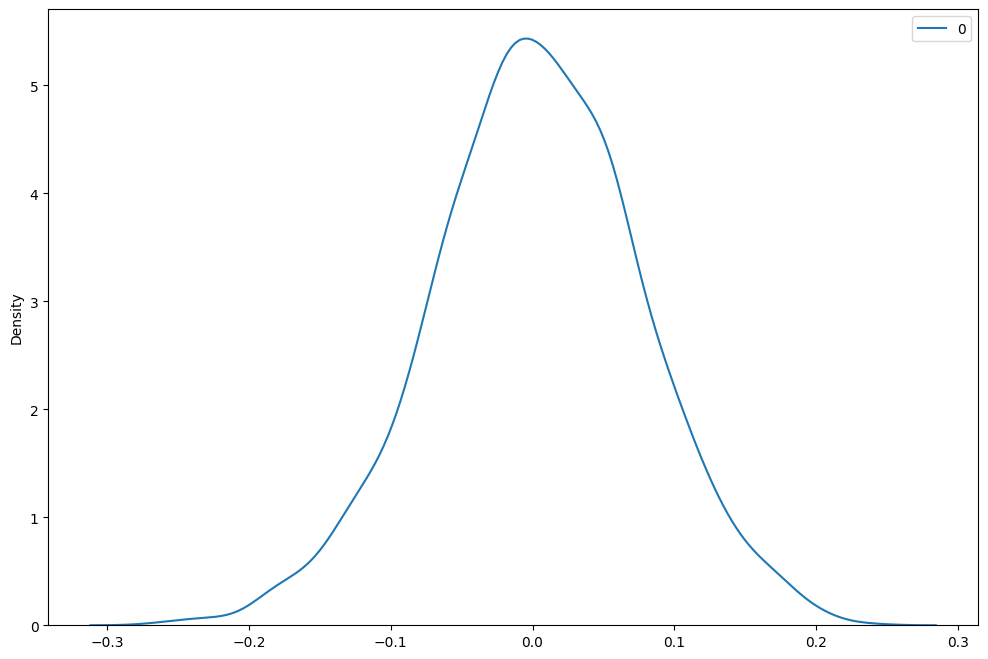

In [49]:
sns.kdeplot(data=hmc_samples['linear.bias']);

In [50]:
hmc_samples['linear.weight'].shape

(2000, 1, 2)

-0.8999912


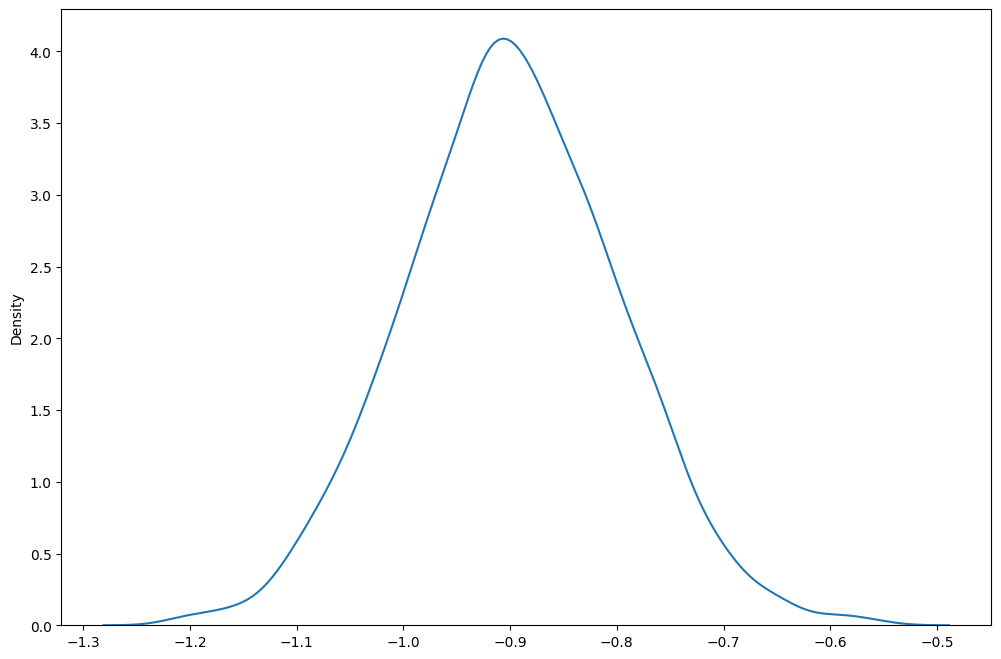

In [51]:
print(np.median(hmc_samples['linear.weight'][:,0,0]))
sns.kdeplot(data=hmc_samples['linear.weight'][:,0,0]);

0.46049097


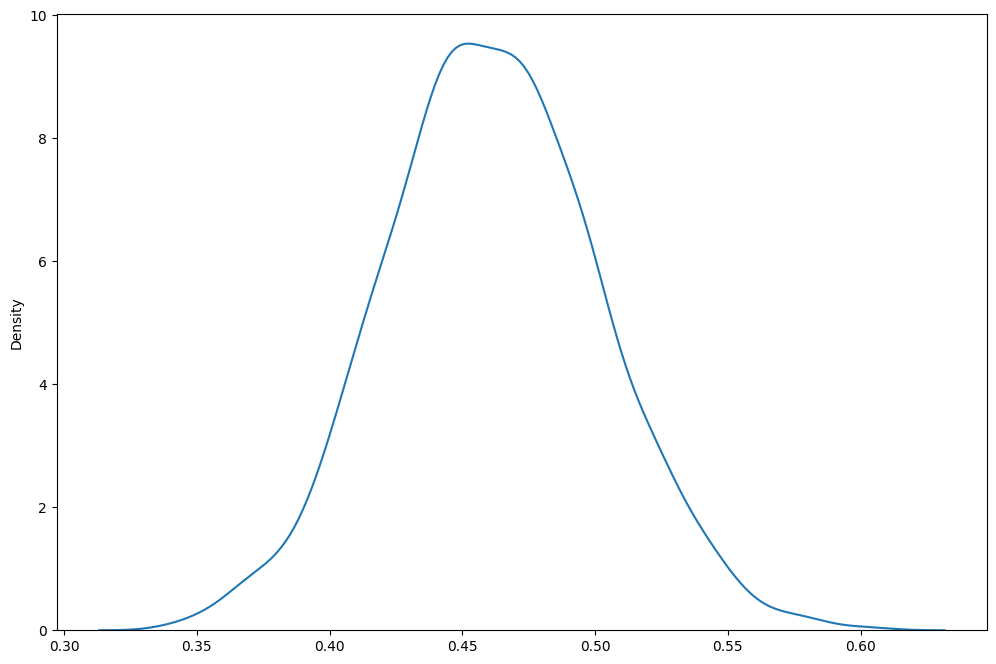

In [52]:
print(np.median(hmc_samples['linear.weight'][:,0,1]))
sns.kdeplot(data=hmc_samples['linear.weight'][:,0,1]);

In [53]:
# sklearn estimate
print(clf.intercept_)
print(clf.coef_)


[0.00274999]
[[-0.89664382  0.46077421]]


tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
tensor([1., 1., 0.,  ..., 0., 0., 1.])


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


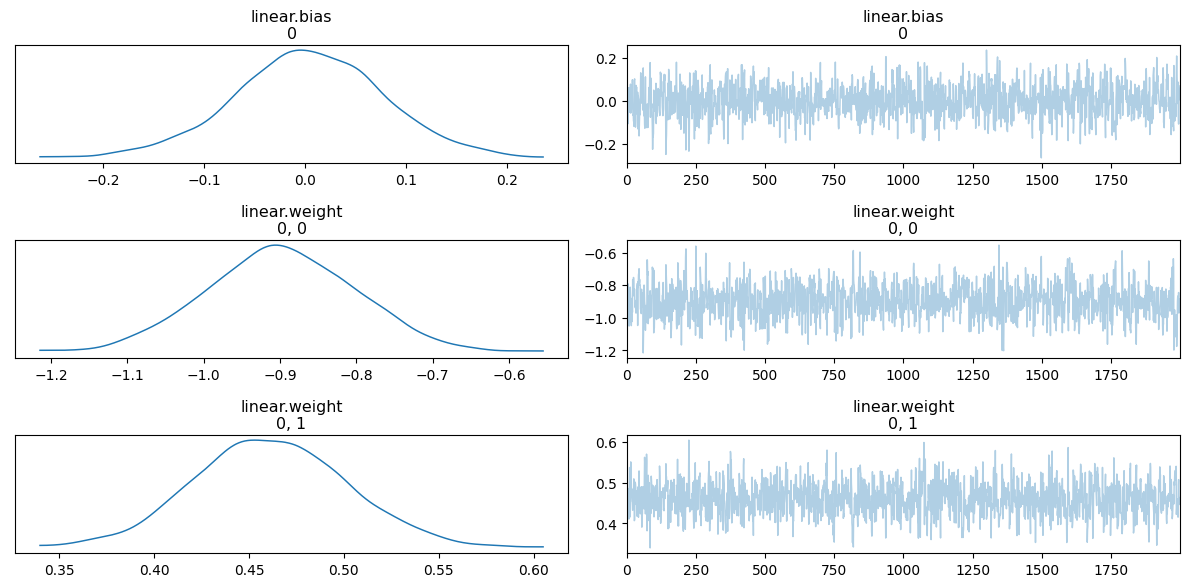

In [54]:
import arviz as az

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data, compact=False)
plt.tight_layout()